# WHAT TO DO
- 번역 추론 결과물을 얻는 시간을 최적화

# WHAT I DID
1. 원본 리뷰 데이터 전처리: 중복을 최대한 제거하여 총 추론 생성 시간 단축
2. 데이터 분포 확인: 추론 데이터 분배를 위한 확인
3. 각 pc에서 추론 시간 비교: desktop, mini-pc, iMac

In [1]:
import pandas as pd

from typing import List
from pprint import pprint
import time
import socket

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")  # 기본 테마 설정 (다른 옵션: darkgrid, white, dark, ticks)

[결과1] 원본 리뷰 데이터 전처리

In [2]:
origin_review_df = pd.read_csv("../downloads/olist/olist_order_reviews_dataset.csv")
print("Size of original reviews:", origin_review_df.shape)

pp_review_df = pd.read_csv("../translate/artifact/preprocessed_reviews.csv")
print("Size of preprocessed reviews:", pp_review_df.shape)

Size of original reviews: (99224, 7)
Size of preprocessed reviews: (42590, 3)


[결과2] 데이터 분포 확인

In [3]:
all_df = pd.read_csv("../translate/artifact/all_portuguess.txt", header=None)
all_df.rename(columns={0: "Portuguess"}, inplace=True)
print(all_df.shape)
print(all_df.dropna().shape)

(38103, 1)
(38103, 1)


In [4]:
all_df.loc[37996:37998]

,Portuguess
37996,dez
37997,dez
37998,ok.


# Pandasd에서 NaN 처리
- pandas에서는 기본적으로 n/a, NA, N/A, 등과 같은 문자열을 **NaN**으로 자동으로 인식하고 처리합니다.
- 이는 read_csv()나 read_excel() 등에서 **누락된 값 (missing value)**을 나타내는 값으로 처리되기 때문입니다.

---
## 해결 방법 1: na_values 옵션 사용
- read_csv() 또는 read_excel()에서 na_values 옵션을 사용하여 특정 문자열을 **NaN**으로 인식하지 않도록 할 수 있습니다.
- 이 옵션을 사용하면 **n/a**를 None으로 읽지 않도록 설정할 수 있습니다.
- 예를 들어, n/a를 None으로 인식하지 않게 하려면 na_values를 조정할 수 있습니다.

```python
import pandas as pd

# n/a를 NaN으로 인식하지 않게 처리
df = pd.read_csv('파일경로.csv', na_values=["n/a", "N/A", "na"])

print(df)
```
---
## 해결 방법 2: keep_default_na=False 사용
- pandas의 read_csv()에서 keep_default_na=False를 설정하면 기본적으로 n/a와 같은 값들을 **NaN**으로 처리하지 않게 할 수 있습니다.

```python
import pandas as pd

# 'n/a'를 NaN으로 변환하지 않도록 설정
df = pd.read_csv('파일경로.csv', keep_default_na=False)

print(df)
```

In [5]:
# 2번 방법으로 해결
all_df = pd.read_csv("../translate/artifact/all_portuguess.txt", header=None, keep_default_na=False)
all_df.rename(columns={0: "Portuguess"}, inplace=True)
print(all_df.shape)
print(all_df.dropna().shape)

(38103, 1)
(38103, 1)


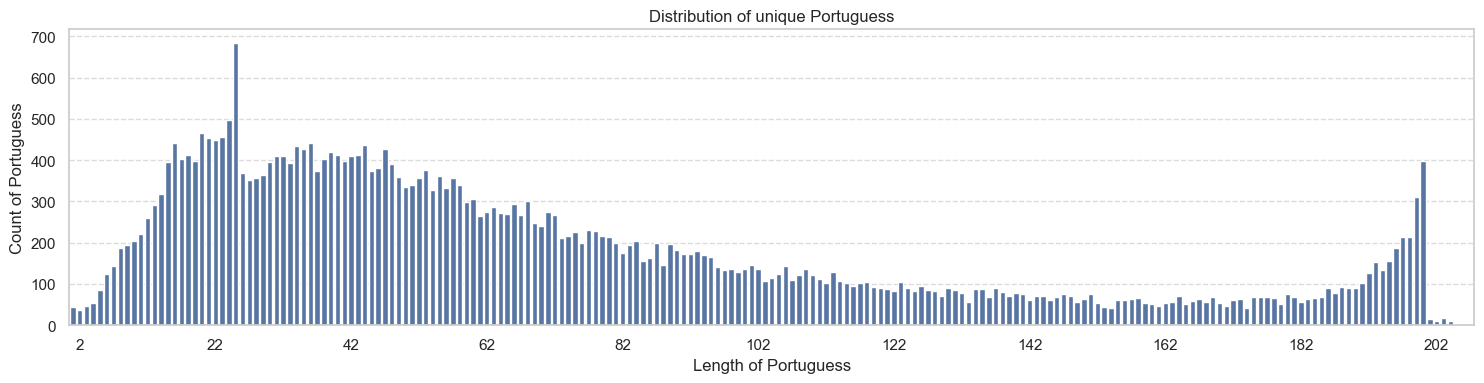

In [6]:
col = "Portuguess"
all_df['len'] = all_df[col].str.len()
data_to_plot = all_df.groupby('len').count()

plt.figure(figsize=(15, 4))
sns.barplot(x=data_to_plot.index, y=col, data=data_to_plot)
plt.title(f"Distribution of unique {col}")
plt.xlabel(f'Length of {col}')
plt.ylabel(f'Count of {col}')
plt.xticks(rotation=0)
if len(data_to_plot) > 40:
    plt.xticks(range(all_df['len'].min(), all_df['len'].max(), 20))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

[결과3] 각 pc에서 추론 시간 비교: desktop, mini-pc, iMac

In [7]:
data_to_plot

,Portuguess
len,
1,44
2,37
3,46
4,54
5,86
...,...
203,17
204,11
206,1


In [8]:
len_list = data_to_plot.index.to_list()
len_list.sort(reverse=True)
min_len_list = len_list[-6:]
max_len_list = len_list[:5]

print(f"- max len: {all_df['len'].max()} ===> top 5 len: {max_len_list}")
print(f"- min len: {all_df['len'].min()} ===> bottom 5 len: {min_len_list}")

- max len: 208 ===> top 5 len: [208, 207, 206, 204, 203]
- min len: 1 ===> bottom 5 len: [6, 5, 4, 3, 2, 1]


In [9]:
for len_ in max_len_list:
    print(len_, all_df[all_df['len'] == len_].iloc[0, 0])

208 não recebi o produto, o produto consta como enviado para o correio de ribeirão preto. o correio não recebeu o produto. envie varias mensagem para a targaryen e não obtive. esta targaryen esta sujando seu nome
207 adquiri 2 mochilas pelo site lannister de e parceiros diferentes. a targaryen de mg entregou bem antes do prazo previsto, sendo que a outra da pacific que vem de sc ainda ñ foi entregue. parabéns a targaryen
206 comprei o produto confiando nas lojas lannister e não na targaryen a qual parece q não entregou o produto no tempo certo para os correios, e não recebi esclarecimento da targaryen, mas o produto chegou, obg
204 na minha compra realizada em 20/09/17 a loja targaryen não teve a mercadoria e até agora nem targaryen, nem stark resolveram. a mercadoria e o frete foram pagos e é o que eu acho que deve ser reembolsado.
203 a targaryen como parceiro da américanas não está em nível de parceiro para um grande nome no mercado. não recomendo para ninguém dos meus amigos para q

In [10]:
import torch
from transformers import pipeline
# from .autonotebook import tqdm as notebook_tqdm

class Translator():
    def __init__(self, device_:str='auto'):
        self.pipe = pipeline("text-generation", model="Unbabel/TowerInstruct-7B-v0.2", torch_dtype=torch.bfloat16, device_map=device_)

    def set_messages(self, portuguess: str) -> None:
        self.messages = [
            {
                "role": "user",
                "content": rf"Translate the following text from Portuguese into Korean.\nPortuguese: {portuguess}\nKorean:"
            }
        ]
        
    def run(self,) -> None:
        prompt = self.pipe.tokenizer.apply_chat_template(self.messages, tokenize=False, add_generation_prompt=True)
        outputs = self.pipe(prompt, max_new_tokens=512, do_sample=False)
        self.output = outputs[0]['generated_text'].split("<|im_start|>assistant\n")[-1].strip()

    def get_output(self,) -> str:
        return self.output

In [11]:
def show_inference_time(translator_: Translator) -> None:
    for len_ in max_len_list:
        ex_str = all_df[all_df['len'] == len_].iloc[0, 0]
        translator_.set_messages(ex_str)
        start = time.time()
        translator_.run()
        end = time.time()
        print(f'The inference time for a message with a string length of {len_} characters: {end-start}')

## On desktop
`auto`
- 시스템에 맞는 최적의 디바이스를 자동으로 선택하고, GPU 메모리 부족 시에도 유연하게 처리

`cuda:0`
- 첫 번째 GPU에 모델을 고정적으로 할당하므로, 메모리가 부족하면 Out of Memory 에러가 발생할 수 있음

### Resource Specification
- VRAM: 12GB -> 모델 로드 후 사용 가능한 메모리: 1.59GB 
- RAM: 32GB

### 1. Device set to use `auto`
Some parameters are on the meta device because they were offloaded to the cpu.
Device set to use cuda:0
- The inference time for a message with `a string length of 208` characters: `122.62772750854492`
- The inference time for a message with `a string length of 207` characters: `112.63686537742615`
- The inference time for a message with `a string length of 206` characters: `87.54716992378235`
- The inference time for a message with `a string length of 204` characters: `90.88418579101562`
- The inference time for a message with `a string length of 203` characters: `101.42228531837463`

### 2. Device set to use `cpu`
Device set to use cpu
- The inference time for a message with `a string length of 208` characters: `106.42066931724548`
- The inference time for a message with `a string length of 207` characters: `109.34600615501404`
- The inference time for a message with `a string length of 206` characters: `90.50024223327637`
- The inference time for a message with `a string length of 204` characters: `89.42259073257446`
- The inference time for a message with `a string length of 203` characters: `100.1663281917572`

In [12]:
# if socket.gethostname() == 'desktop':
#     show_inference_time(Translator('auto'))
#     show_inference_time(Translator('cpu'))

# else: # 'mini-pc' or 'iMac'
#     show_inference_time(Translator())